In [1]:
%pylab inline

import seaborn
import matplotlib.pyplot as plt
import natto
import IPython
import numpy

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

#from descr import boxy_notebook
#from descr.util import Table
#import pprint 
# pr = boxy_notebook(always_setup = True)

d = sc.textFile("/root/ukpolice/2014-*/*-street.csv")

Populating the interactive namespace from numpy and matplotlib


In [2]:
def pr(x):
    return IPython.display.HTML(natto.natto(x,with_css=True))

In [3]:
d.count()

5656486

In [4]:
header = d.take(1)[0]
datarows = d.filter( lambda x: x != header )
print header

Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context


In [5]:
print datarows.take(1) 
pr( datarows.map( lambda x: (len(x.split(",")),1) ).countByKey() )

[u',2014-05,Essex Police,Essex Police,0.439197,51.642719,On or near Potash Road,E01021237,Basildon 001A,Anti-social behaviour,,']


In [6]:
okdata = datarows.map( lambda x: x.split(",")).filter( lambda x: len(x) == 12 )
hdrdata = header.split(",")
print hdrdata
print okdata.count(), len(hdrdata)

[u'Crime ID', u'Month', u'Reported by', u'Falls within', u'Longitude', u'Latitude', u'Location', u'LSOA code', u'LSOA name', u'Crime type', u'Last outcome category', u'Context']
5655827 12


In [7]:
semidata = okdata.map( lambda x: dict( zip( hdrdata, x )))
# extract a single row (as a dictionary) and display it as a table
pr(semidata.take(1)[0])

In [12]:
# map the dictionaries into rows, infer the schema and register them with the sql context as a table
rows = semidata.map(lambda x: pyspark.sql.Row(**x))
df = sqlContext.createDataFrame(rows)
df.registerAsTable("crime")

In [14]:
# count the number of occurences for each crime-type and outcome combination
counts = sqlContext.sql( """select `Crime type`, `Last outcome category`, count(*) as count from crime group by `Crime type`, `Last outcome category` """).collect()

Public order


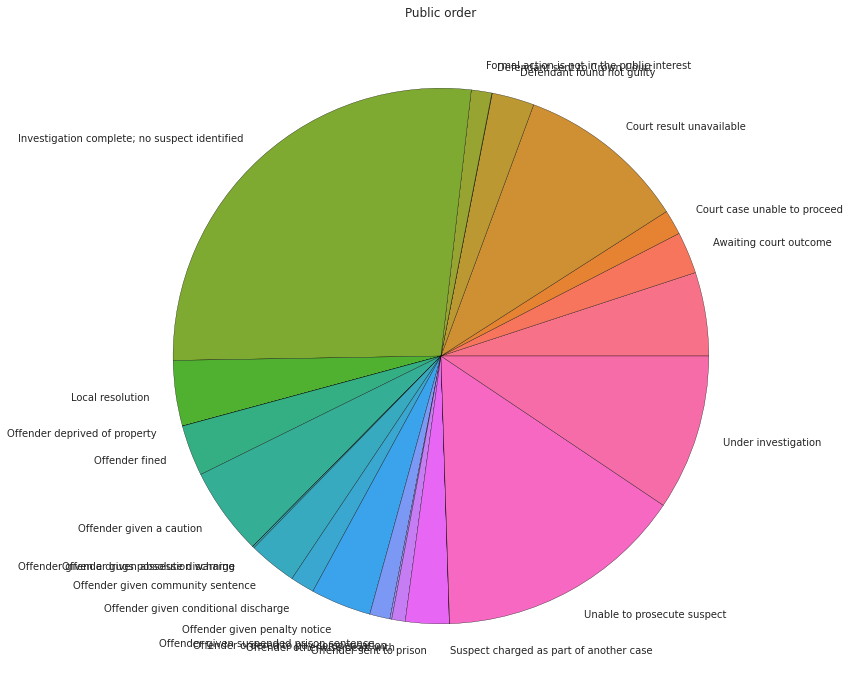

In [17]:
# fetch distinct categories of crimes and outcomes
crimetypes = sqlContext.sql("select distinct `Crime type` from crime").rdd.map(lambda x:x[0]).collect()
outcometypes = sqlContext.sql("select distinct `Last outcome category` from crime").rdd.map(lambda x:x[0]).collect()

# pick a crimetype to visualise
ct = crimetypes[6]
print ct

# retrieve the aggregates for the selected crime type, visualize as pie-chart
selectedoutcomes = {outcome:cnt for ctype,outcome,cnt in counts if ctype==ct}
labels = sorted(selectedoutcomes.keys())
sizes = [selectedoutcomes[key] for key in labels]

pcolors = seaborn.color_palette( "husl",n_colors = len(labels) )

plt.figure(figsize=(12,12))
plt.pie(sizes, labels=labels, colors=pcolors)
plt.title(ct)
None

In [18]:
# to draw a heatmap of outcomes per crime, we need to normalize the numbers within each crime-type
cols = crimetypes
rows = sorted(outcometypes) # all outcome types

# turn the retrieved values into a matrix of absolute counts
stats = numpy.zeros( (len(rows),len(cols)) ,dtype=float )
for ctype,outcome,cnt in counts:
    stats[rows.index(outcome),cols.index(ctype)] = cnt

# generic normalization function, can work on 2d arrays to normalize across
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)
    
stats = normalized(stats,axis=0)


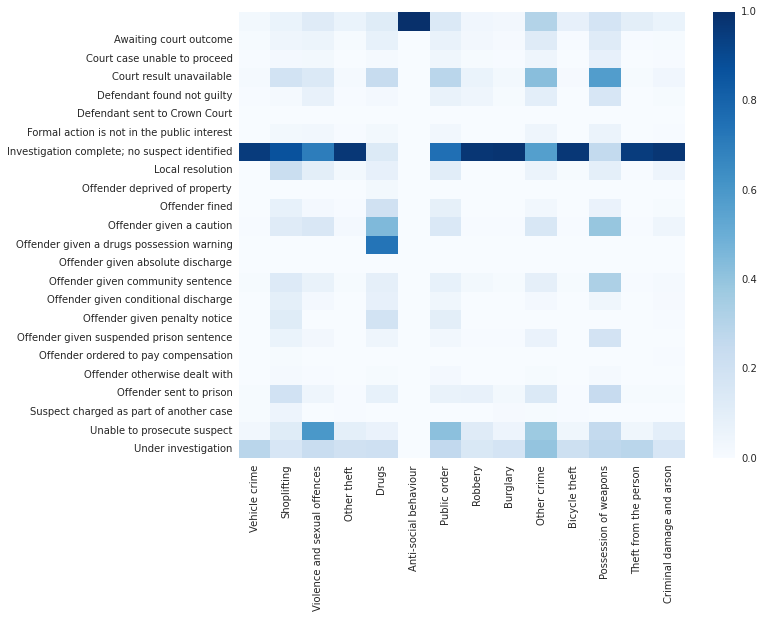

In [19]:
plot=seaborn.heatmap(stats,xticklabels=cols,yticklabels=rows,cmap=matplotlib.pylab.cm.Blues)

In [21]:
# which regions are similar in the type of crimes they handle?
# first we define a feature vector that has a vector of occurrences for each crime type

# for a single record, produces an array of zero's of size len(crimetype), with a 1 of the crimetype for that record
def mkFeature(d):
    f = numpy.zeros((len(crimetypes)),dtype = float)
    f[crimetypes.index(d['Crime type'])] = 1.0
    return f

def normalizeFeature( f ):
    f = f.flatten()
    return f / numpy.sum(f)

# build a map of reporting region to feature vector by summing the feature vectors together
featureVectors = semidata.map( lambda x: (x['Reported by'],mkFeature(x)) ).reduceByKey( lambda x,y : x + y )

# collect locally as a map of region -> featurevector
fmap = featureVectors.mapValues( normalizeFeature ).collectAsMap()



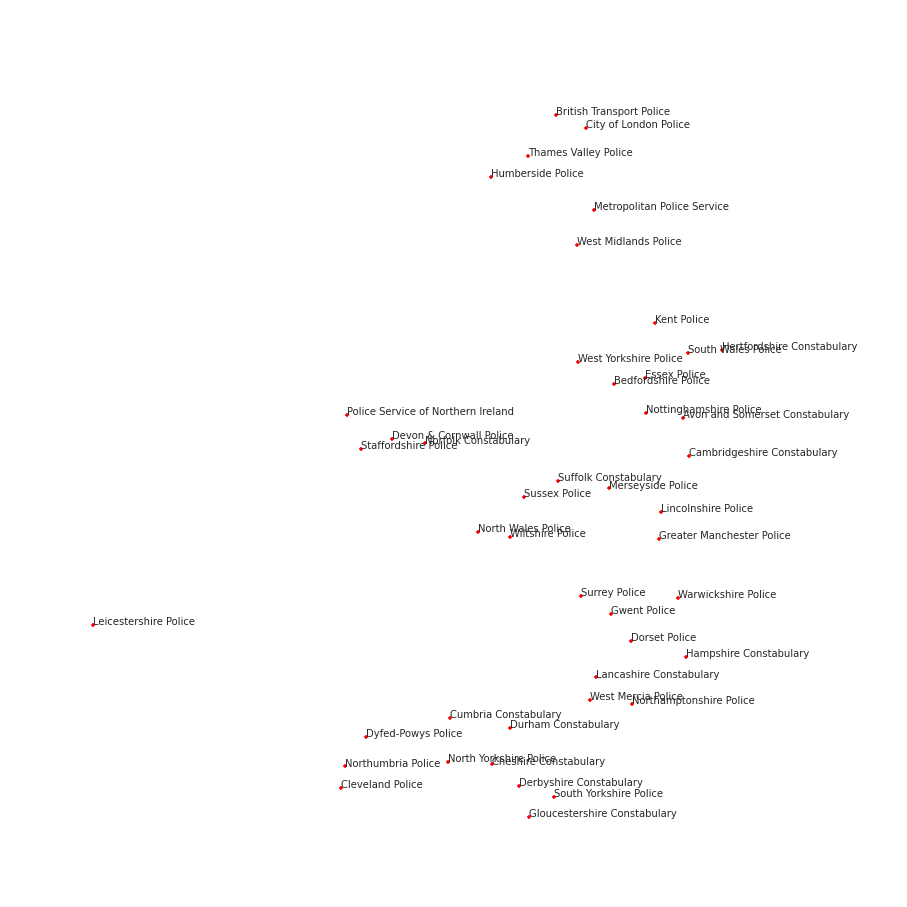

In [22]:
# embed the feature vectors
import tsne

# using the t-stochastic neighbourhood embedding, we can map the feature vectors to a two-dimensional embedding
embedding = tsne.bh_sne(numpy.array(fmap.values()),perplexity=4)

# for each 2d point in the resulting embedding, closeness resembles closeness in the original space
# so regions that had similar types of crimes will be close to eachother

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, axisbg='white')

# plot the embedded coordinates
matplotlib.pyplot.plot( embedding[:,0], embedding[:,1], 'r.')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# label the points
for region, pnt in zip(fmap.keys(),embedding):
    ax.annotate(region, xy=pnt )

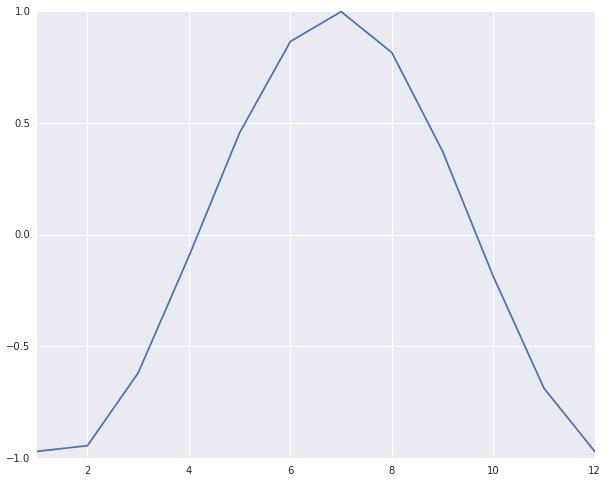

In [23]:
# to look at seasonal effects we first build the aggregates by crimetype/month combination

monthly_counts = semidata.map( lambda x: ((x['Crime type'], int(x['Month'][-2:],10)),1)).countByKey()

# build a seasonal temperature curve and show how temperature varies over the 12 months of the year
season = -cos(2.0*3.1415*numpy.linspace(0,1,12) -0.24)
pylab.plot(range(1,13),season)
pylab.xlim([1,12])
pylab.show()

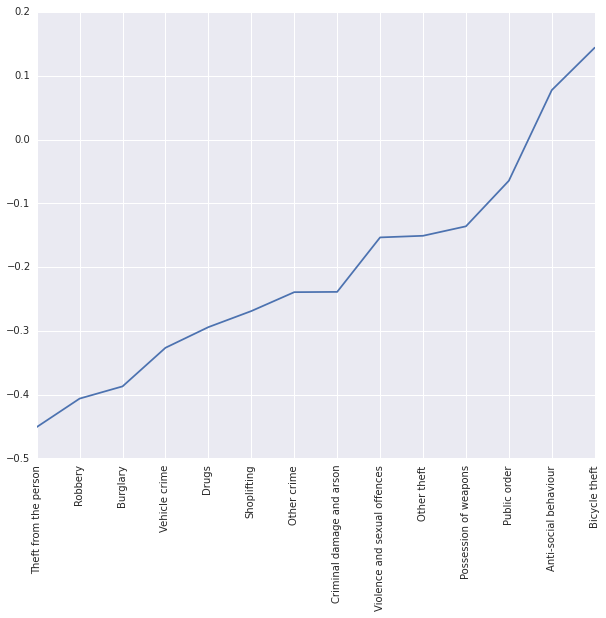

In [24]:
rows = sorted(list(set([x[0] for x in monthly_counts.keys()])))
cols = sorted(list(set([x[1] for x in monthly_counts.keys()])))

# build an array of crime counts, with month and crimetype as axes
countarray = numpy.zeros(  (len(rows),len(cols)), dtype=float )
for k,v in monthly_counts.items():
    countarray[ rows.index(k[0]), cols.index(k[1]) ] = v

# normalize the occurrences per crimetype
countarray = normalized(countarray,axis=1)

# take the dot-product for each crimetype, between the per-month counts and the per-month temperature, and sort by correlation
ranked = sorted( zip(countarray.dot(season),countarray,rows) )

# plot the correlated ranked labels in increasing order (winter to summer)
lplot = pylab.plot([x[0] for x in ranked])
pylab.xticks(range(len(ranked)), [x[2] for x in ranked], rotation='vertical')
pylab.xlim([0,len(ranked)-1])
pylab.show()


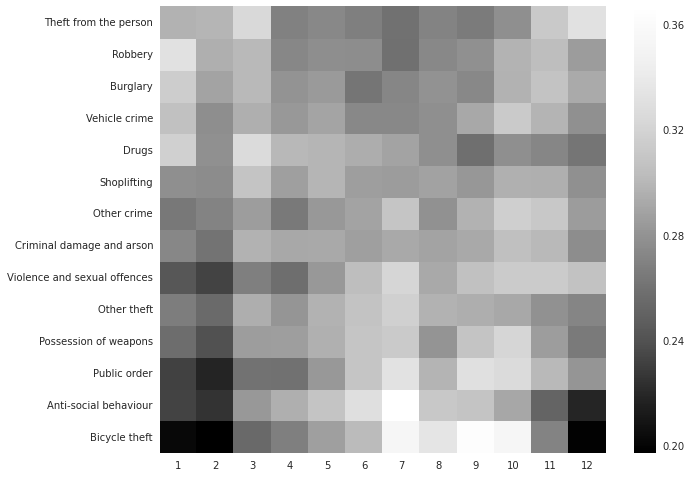

In [25]:
# plot the raw counts in the same order
sorted_countarray = [x[1] for x in ranked]
sorted_rows = [x[2] for x in ranked]

hplot = seaborn.heatmap(sorted_countarray,xticklabels=cols, yticklabels=sorted_rows, cmap=matplotlib.pylab.cm.Greys_r)